# Project Milestone 2 Notebook
## Do Americans prefer beers with a higher alcohol content (ABV) than Europeans?
- Is it linked to the beer style? Do they generally prefer beer styles that have a higher ABV? (Grouping + micro/macro averages)
- Has it evolved between 2000 and 2017? (Time series analysis + maybe regression)
- Can we map American States to European countries? (Graph/network algorithms)

## 0. Imports and global variables

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from load_data import load_gzip_txt_data

## 1. Preprocessing of the data:

#### 1.0 Split users between North America and Europe:

Define European countries:

In [19]:
european_countries = [
    "Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus",
    "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus",
    "Czech Republic", "Denmark", "England", "Estonia", "Finland", "France", "Georgia",
    "Germany", "Gibraltar", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Jersey", "Kazakhstan",
    "Kosovo", "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", "Malta",
    "Moldova", "Monaco", "Montenegro", "Netherlands", "Northern Ireland", "Macedonia",
    "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Scotland", "Serbia",
    "Slovakia", "Slovak Republic", "Slovenia", "Spain", "Sweden", "Switzerland", "Turkey",
    "Ukraine", "Vatican City", "Wales"
]

# /!\ Slovakia in RateBeer and Slovak Republic in BeerAdvocate /!\

Load users files and classify if European, North American or neither:

In [20]:
def get_na_or_eu(row):
    """
    In a Dataframe with a column "location", returns whether the location 
    is in Europe or North America.
    
    :param row: pandas.Dataframe row with an attribute "location".
    :return: str, can be "NA", "EU" or "Other".
    """
    location = row['location']
    if location in european_countries:
        return 'EU'
    elif (location == 'Canada') or ("United States" in str(location)):
        return 'NA'
    else:
        return 'Other'


ba_users_df = (pd.read_csv("./data/BeerAdvocate/users.csv").drop(
    columns=['nbr_ratings', 'nbr_reviews', 'user_name', 'joined'])
               .dropna())
ba_users_df['eu_na'] = ba_users_df.apply(get_na_or_eu, axis=1)

rb_users_df = (pd.read_csv("./data/RateBeer/users.csv").drop(
    columns=['nbr_ratings', 'user_name', 'joined'])
               .dropna())
rb_users_df['eu_na'] = rb_users_df.apply(get_na_or_eu, axis=1)

print("BeerAdvocate:")
display(ba_users_df)
print("RateBeer:")
display(rb_users_df)

BeerAdvocate:


,user_id,location,eu_na
0,nmann08.184925,"United States, Washington",NA
1,stjamesgate.163714,"United States, New York",NA
2,mdagnew.19527,Northern Ireland,EU
3,helloloser12345.10867,Northern Ireland,EU
4,cypressbob.3708,Northern Ireland,EU
...,...,...,...
153698,eturchick.374415,"United States, California",NA
153699,everman.532342,"United States, California",NA
153700,justin0001.352175,"United States, California",NA
153702,joetex.800347,"United States, California",NA


RateBeer:


,user_id,location,eu_na
0,175852,Poland,EU
1,442761,Spain,EU
2,288889,Poland,EU
3,250510,Spain,EU
4,122778,Germany,EU
...,...,...,...
70167,181614,Norway,EU
70169,134893,England,EU
70170,327816,Belgium,EU
70172,82020,Slovenia,EU


Let's analyze the repartition of NA/EU/Other users:

In [21]:
print("BeerAdvocate:")
display(ba_users_df['eu_na'].value_counts())
print("RateBeer:")
display(rb_users_df['eu_na'].value_counts())

BeerAdvocate:


NA       116547
EU         3944
Other      1934
Name: eu_na, dtype: int64

RateBeer:


NA       30110
EU       16156
Other     4326
Name: eu_na, dtype: int64

Clearly, the vast majority of users comes from North America, followed by Europe especially in the BeerAdvocate dataset. In the following analysis, we will only consider NA and EU users.


In [22]:
ba_users_df = ba_users_df.query("eu_na != 'Other'")
rb_users_df = rb_users_df.query("eu_na != 'Other'")

#### 1.1 Load the ratings:

Load the ratings files:

In [180]:
ba_ratings_df = load_gzip_txt_data("./data/BeerAdvocate/ratings.txt.gz",
                                   ["user_id", "date", "abv", "style", "rating", "appearance", "aroma", "palate",
                                    "taste", "overall"])
rb_ratings_df = load_gzip_txt_data("./data/RateBeer/ratings.txt.gz",
                                   ["user_id", "date", "abv", "style", "rating", "appearance", "aroma", "palate",
                                    "taste", "overall"])

Loading data from:  ./data/BeerAdvocate/ratings.txt.gz


151074576it [02:38, 950859.31it/s] 


Loading data from:  ./data/RateBeer/ratings.txt.gz


121075258it [02:37, 768964.83it/s] 


Cast the columns to meaningful types:

In [181]:
ba_ratings_df = ba_ratings_df.astype({
    'user_id': 'str',
    'date': 'int64',
    'abv': 'float32',
    'rating': 'float32'})

rb_ratings_df = rb_ratings_df.astype({
    'user_id': 'int64',
    'date': 'int64',
    'abv': 'float32',
    'rating': 'float32'})

# Convert the dates to monthly periods (useful for plotting):
ba_ratings_df['date'] = pd.to_datetime(ba_ratings_df['date'], unit='s').dt.to_period('m').astype('datetime64[M]')
rb_ratings_df['date'] = pd.to_datetime(rb_ratings_df['date'], unit='s').dt.to_period('m').astype('datetime64[M]')

#### 1.2 Group similar beer styles into broader groups

Defined the broad groups using https://www.beeradvocate.com/beer/styles/, so we can just load the csv file containing the matching specific type -> general type:

In [182]:
beer_styles_matching = pd.read_csv("./data/additional/styles_matching.csv", index_col='specific')['general'].to_dict()
print(f"General styles:\n{set(beer_styles_matching.values())}")

General styles:
{'Brown Ales', 'Pale Lagers', 'Saké', 'Bocks', 'Wild/Sour Beers', 'Hybrid Beers', 'Dark Ales', 'Dark Lagers', 'India Pale Ales', 'Wheat Beers', 'Specialty Beers', 'Porters', 'Stouts', 'Strong Ales', 'Pale Ales'}


Note: we don't want to take the Saké into account as it is not a beer!

Replace the specific beer style by the general style (and drop Saké ratings):

In [183]:
def specific_style_to_general(row):
    return beer_styles_matching[row['style']]

ba_ratings_df['style'] = ba_ratings_df.apply(specific_style_to_general, axis=1)
rb_ratings_df['style'] = rb_ratings_df.apply(specific_style_to_general, axis=1)

# Drop Saké
ba_ratings_df = ba_ratings_df.query("style != 'Saké'")
rb_ratings_df = rb_ratings_df.query("style != 'Saké'")

In [184]:
print("BeerAdvocate:")
display(ba_ratings_df.sample(10))
print("RateBeer:")
display(rb_ratings_df.sample(10))

BeerAdvocate:


,user_id,date,abv,style,rating,appearance,aroma,palate,taste,overall
7966795,lambicpentameter.691798,2014-03-01,5.0,Wild/Sour Beers,4.84,4.5,4.75,4.75,5.0,4.75
8311983,jtuomi.772206,2013-12-01,5.5,Pale Lagers,3.00,nan,nan,nan,nan,nan
5501999,andrew8626.577293,2013-03-01,5.0,Pale Lagers,3.75,nan,nan,nan,nan,nan
7821953,stephens101.77452,2014-06-01,6.5,Wild/Sour Beers,4.36,4.0,4.25,4.5,4.5,4.25
5274481,hopjack13.2120,2003-09-01,18.0,India Pale Ales,2.63,3.5,3.0,2.0,2.5,2.5
5051209,timfore.485644,2013-11-01,8.5,India Pale Ales,4.25,nan,nan,nan,nan,nan
8192418,haveuseenmycellar.691999,2014-02-01,8.5,Strong Ales,4.75,nan,nan,nan,nan,nan
1435677,nivek43.667682,2014-04-01,15.2,Strong Ales,4.50,nan,nan,nan,nan,nan
4527584,outoffocus.702797,2013-03-01,9.5,Strong Ales,4.25,nan,nan,nan,nan,nan
4281354,lucasj82.359616,2014-07-01,4.2,Pale Lagers,3.00,nan,nan,nan,nan,nan


RateBeer:


,user_id,date,abv,style,rating,appearance,aroma,palate,taste,overall
6426722,2778,2006-02-01,3.0,Specialty Beers,2.4,4,5,2,4,9
6479478,134438,2014-01-01,8.3,Strong Ales,4.1,4,8,4,8,17
16356,87513,2014-04-01,4.0,Pale Lagers,1.3,2,3,2,2,4
6782830,17613,2006-07-01,5.5,Wild/Sour Beers,2.9,4,6,3,5,11
1195790,10924,2005-06-01,8.2,Wheat Beers,4.6,5,8,5,9,19
4763222,95690,2013-05-01,5.3,Pale Ales,4.0,4,7,5,8,16
4649739,5931,2010-04-01,5.5,Pale Ales,2.8,4,6,2,5,11
5283733,5566,2002-10-01,6.0,Pale Ales,3.8,5,8,4,6,15
4895123,91618,2016-01-01,6.1,Hybrid Beers,3.8,3,7,4,8,16
470015,106360,2012-04-01,5.2,Dark Lagers,2.1,3,5,2,5,6


#### 1.3 Merge the users with the ratings

In [185]:
ba_df = ba_ratings_df.merge(ba_users_df, on='user_id').drop(columns=['user_id'])
rb_df = rb_ratings_df.merge(rb_users_df, on='user_id').drop(columns=['user_id'])

In [186]:
print("BeerAdvocate:")
display(ba_df)
print("RateBeer:")
display(rb_df)

BeerAdvocate:


,date,abv,style,rating,appearance,aroma,palate,taste,overall,location,eu_na
0,2015-08-01,4.5,Pale Lagers,2.88,3.25,2.75,3.25,2.75,3.0,"United States, Washington",NA
1,2015-11-01,5.0,Pale Ales,3.56,4.0,3.5,3.75,3.5,3.5,"United States, Washington",NA
2,2011-11-01,8.0,Strong Ales,4.50,nan,nan,nan,nan,nan,"United States, Washington",NA
3,2013-05-01,10.5,Strong Ales,3.75,nan,nan,nan,nan,nan,"United States, Washington",NA
4,2015-01-01,6.0,Porters,3.81,4.0,3.5,3.75,4.0,3.75,"United States, Washington",NA
...,...,...,...,...,...,...,...,...,...,...,...
7806408,2012-01-01,10.1,India Pale Ales,1.00,nan,nan,nan,nan,nan,"United States, California",NA
7806409,2014-04-01,10.1,India Pale Ales,4.54,4.75,4.5,4.75,4.5,4.5,"United States, California",NA
7806410,2011-06-01,8.0,India Pale Ales,2.08,3.0,2.5,3.0,1.5,2.0,"United States, California",NA
7806411,2014-05-01,6.0,Pale Ales,4.45,3.5,4.0,4.75,4.75,4.5,"United States, California",NA


RateBeer:


,date,abv,style,rating,appearance,aroma,palate,taste,overall,location,eu_na
0,2016-04-01,5.0,Pale Lagers,2.0,2,4,2,4,8,Poland,EU
1,2015-05-01,5.2,Pale Lagers,1.7,2,4,2,3,6,Poland,EU
2,2015-04-01,4.5,Pale Lagers,1.9,3,4,2,4,6,Poland,EU
3,2015-04-01,5.3,Brown Ales,3.7,4,7,4,8,14,Poland,EU
4,2015-11-01,6.1,Brown Ales,2.5,4,6,3,5,7,Poland,EU
...,...,...,...,...,...,...,...,...,...,...,...
6636932,2014-07-01,5.0,Pale Lagers,2.6,3,3,3,5,12,Belgium,EU
6636933,2008-09-01,4.7,Pale Lagers,0.5,1,1,1,1,1,Slovenia,EU
6636934,2008-09-01,4.5,Dark Lagers,3.9,4,7,5,6,17,Slovenia,EU
6636935,2008-09-01,4.0,Pale Lagers,2.7,5,4,3,5,10,Slovenia,EU


## 2. General Analysis 

In [295]:
# TODO: Plot some stuff using what we have here: NA or EU, ABV values, 14 possible styles, sensory ratings (can be nan), and precise location (maybe keep this for later).

# TODO: Do we want to use a bit of NLP ? Not sure how to do it in a meaningful way...

# TODO: /!\ Please plot with seaborn if it can be simpler (mainly for automatic CI) I beg you ^^

### 2.1 First insights

In the following, we compare the ratings for both datasets BeerAdvocate and RateBeer over time

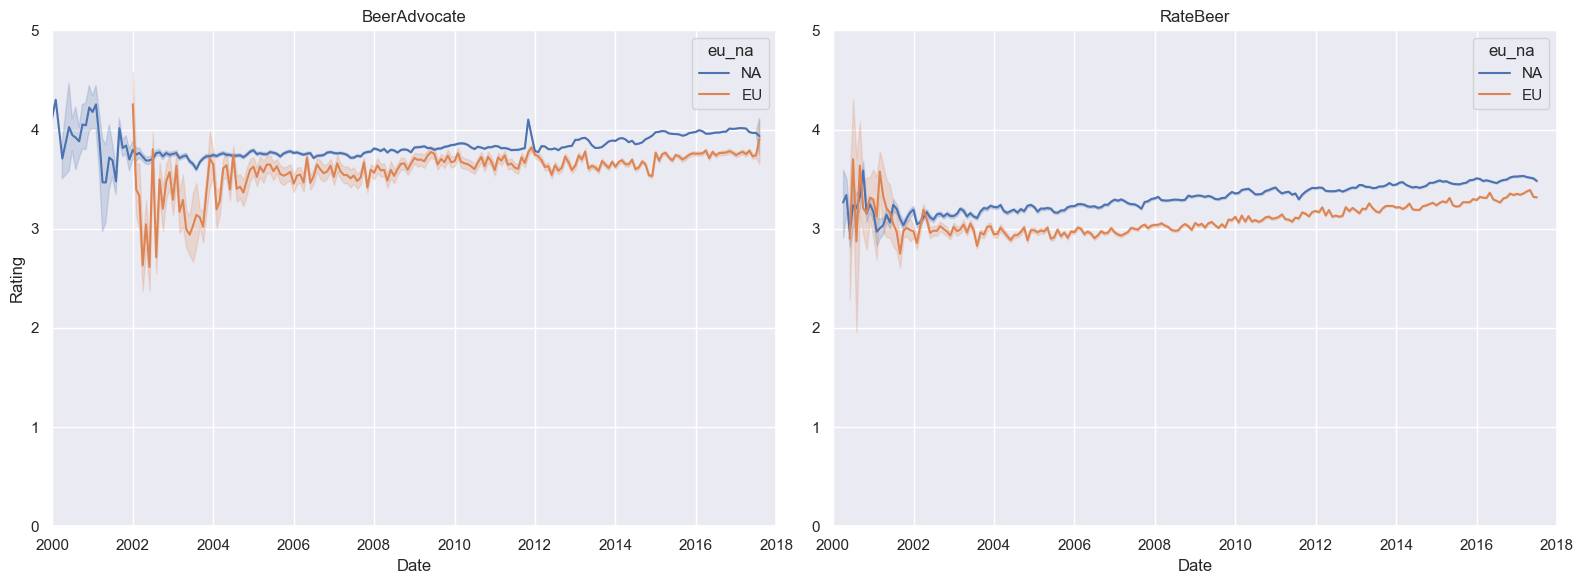

In [187]:
sns.set_theme()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
hue_order = ['NA', 'EU']
sns.lineplot(data=ba_df, x='date', y='rating', hue='eu_na', hue_order=hue_order, ax=axes[0])
sns.lineplot(data=rb_df, x='date', y='rating', hue='eu_na', hue_order=hue_order, ax=axes[1])
axes[0].set(xlabel="Date", 
            ylabel="Rating", 
            title="BeerAdvocate", 
            xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01')),
            ylim=(0, 5))
axes[1].set(xlabel="Date",
            ylabel="",
            title="RateBeer",
            xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01')),
            ylim=(0, 5))

plt.tight_layout()
plt.show()

In [188]:
# Evaluating mean ratings

ba_NA_mean_rating = ba_df.query("eu_na == 'NA'")['rating'].mean()
ba_EU_mean_rating = ba_df.query("eu_na == 'EU'")['rating'].mean()
ba_mean_tot = ba_df['rating'].mean()

rb_NA_mean_rating = rb_df.query("eu_na == 'NA'")['rating'].mean()
rb_EU_mean_rating = rb_df.query("eu_na == 'EU'")['rating'].mean()
rb_mean_tot = rb_df['rating'].mean()

print(f'The mean rating in BeerAdvocate is {ba_mean_tot:.2f}.\n'
      f'The mean rating in RateBeer is {rb_mean_tot:.2f}.\n'
      f'The mean difference between EU and NA in BeerAdvocate is {ba_NA_mean_rating - ba_EU_mean_rating:.2f}.\n'
      f'The mean difference between EU and NA in RateBeer is {rb_NA_mean_rating - rb_EU_mean_rating:.2f}.\n')

The mean rating in BeerAdvocate is 3.84.
The mean rating in RateBeer is 3.32.
The mean difference between EU and NA in BeerAdvocate is 0.17.
The mean difference between EU and NA in RateBeer is 0.17.



BeerAdvocate receives better reviews on average than RateBeer, but the difference between NA and EU user ratings remains the same, where Europeans give harsher ratings on average. There's much more noise initially due to fewer reviews per month

We Furthermore consider the review frequency for both datasets:

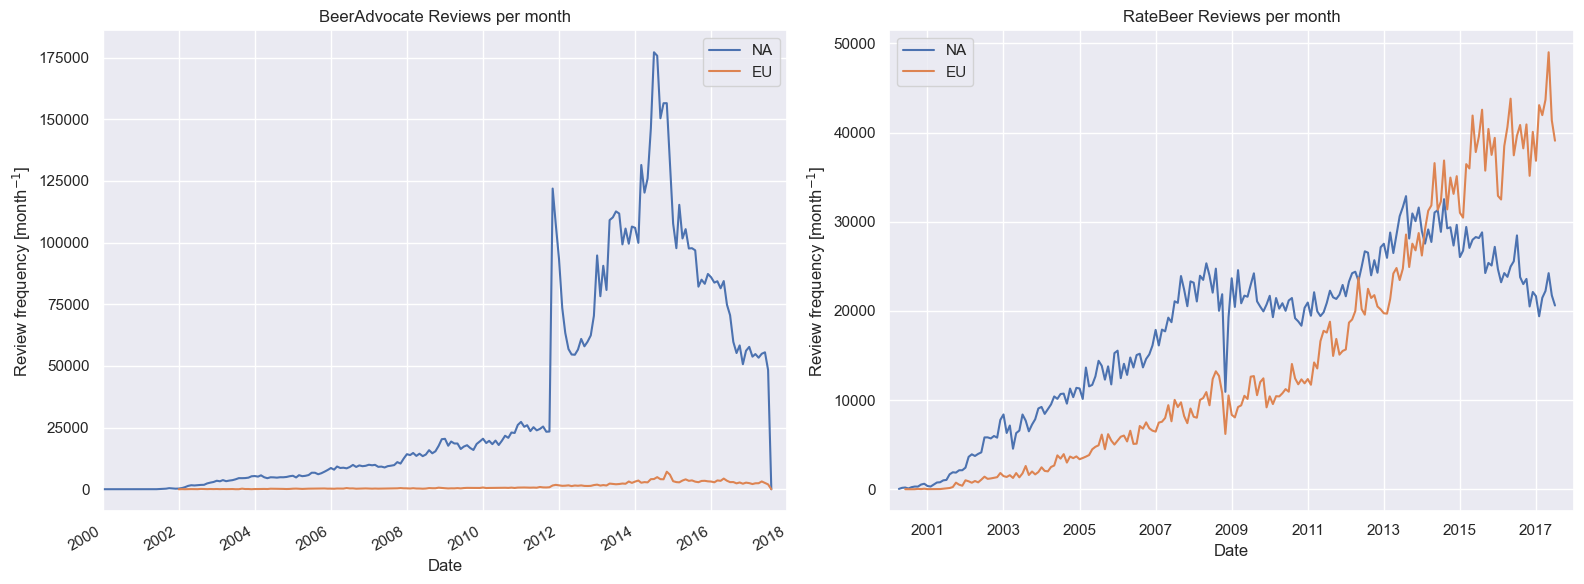

In [190]:
# I don't know how to use sns when grouping stuff together, sorry :( Not sure if we should even use those plots
# I wanted to see the behavior though -> dunno if sns.countplot can use lines, the default setting does not help because
# it plots every month as bin, it looks awful - but don't have CI here..

df_rb_eu = rb_df[rb_df['eu_na'] == 'EU']
df_rb_na = rb_df[rb_df['eu_na'] == 'NA']
df_ba_eu = ba_df[ba_df['eu_na'] == 'EU']
df_ba_na = ba_df[ba_df['eu_na'] == 'NA']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_ba_na.groupby('date')['rating'].count().plot(label='NA', ax=axes[0])
df_ba_eu.groupby('date')['rating'].count().plot(label='EU', ax=axes[0])
axes[0].set(xlabel="Date", 
            ylabel="Review frequency [month$^{-1}$]", 
            title="BeerAdvocate Reviews per month",
            xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01')))
axes[0].legend()

df_rb_na.groupby('date')['rating'].count().plot(label='NA', ax=axes[1])
df_rb_eu.groupby('date')['rating'].count().plot(label='EU', ax=axes[1])
axes[1].set(xlabel="Date", 
            ylabel="Review frequency [month$^{-1}$]", 
            title="RateBeer Reviews per month",
            xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01')))
axes[1].legend()

plt.tight_layout()
plt.show()

[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Rating'),
 Text(0.5, 1.0, 'RateBeer'),
 (10957.0, 17532.0)]

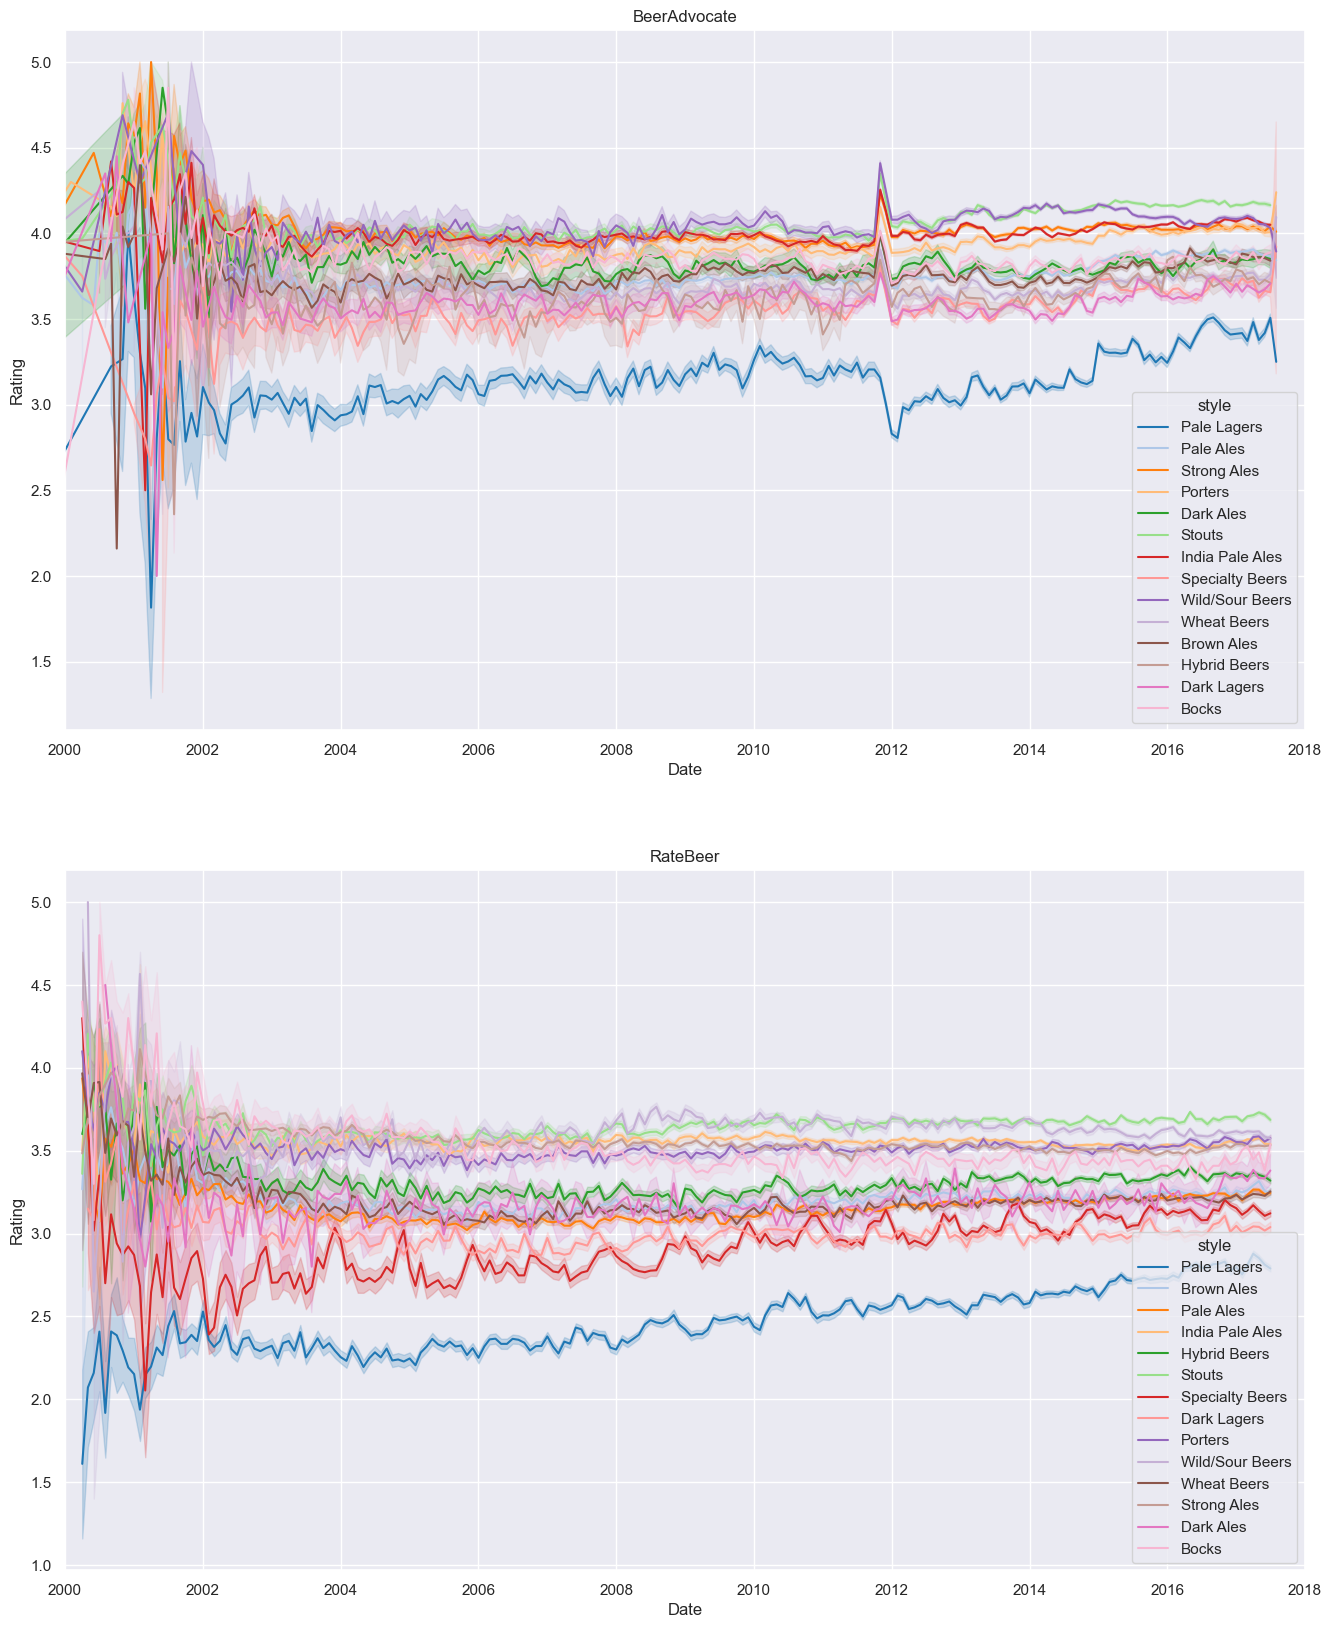

In [197]:
fig, axes = plt.subplots(2, 1, figsize=(16, 20))

sns.lineplot(data=ba_df, x='date', y='rating', hue='style', ax=axes[0], palette='tab20')
sns.lineplot(data=rb_df, x='date', y='rating', hue='style', ax=axes[1], palette='tab20')
axes[0].set(xlabel="Date",
            ylabel="Rating",
            title="BeerAdvocate",
            xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01')))
axes[1].set(xlabel="Date",
            ylabel="Rating",
            title="RateBeer",
            xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01')))

The spike in 2012 in BeerAdvocate can be traced back to a drastic increase of reviews in BeerAdvocate at that time

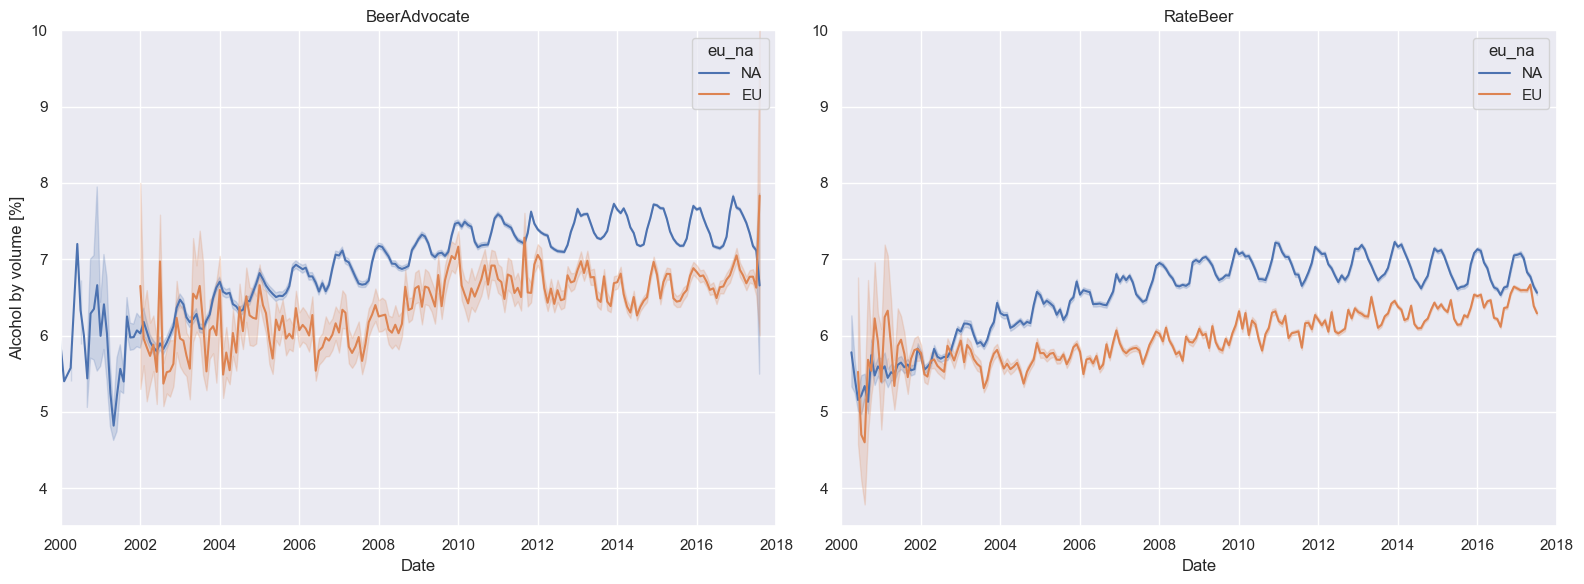

In [196]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
hue_order = ['NA', 'EU']
sns.lineplot(data=ba_df, x='date', y='abv', hue='eu_na', hue_order=hue_order, ax=axes[0])
sns.lineplot(data=rb_df, x='date', y='abv', hue='eu_na', hue_order=hue_order, ax=axes[1])
axes[0].set(xlabel="Date", 
            ylabel="Alcohol by volume [%]", 
            title="BeerAdvocate", 
            xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01')),
            ylim=(3.5, 10))

axes[1].set(xlabel="Date",
            ylabel="",
            title="RateBeer",
            xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01')),
            ylim=(3.5, 10))

plt.tight_layout()
plt.show()

Northern Americans drink more alcoholic beers than Europeans on average, interestingly there's a strong seasonality in ABV, we observe oscillations that reach their maxima during winter each year (by $\sim$ 0.5%). Also people consume higher ABV beers than 20 years ago